# Notebook 3: Análise do Poder Calorífico Superior (PCS)

## Curso ABAR - Medições Inteligentes e Gestão Integrada

### Objetivo
Analisar o PCS (Poder Calorífico Superior) do gás natural na entrada do distrito.

### Conceitos-chave
- **PCS (Poder Calorífico Superior):** Energia total liberada na combustão completa de 1 m³ de gás, incluindo calor de condensação do vapor d'água
- Unidade: **kcal/m³** (quilocalorias por metro cúbico nas condições de referência)
- O PCS depende da **composição do gás** (obtida por cromatografia)
- Variações no PCS afetam diretamente o **valor comercial** do gás: Energia = Volume × PCS
- Gás de boa qualidade tem PCS mais alto → mais energia por m³

In [1]:
import sys
from pathlib import Path

# Configurar caminhos do projeto
PROJECT_ROOT = Path('.').resolve().parent if Path('.').resolve().name == 'notebooks' else Path('.').resolve()
sys.path.insert(0, str(PROJECT_ROOT / 'src'))
from config import DATA_DIR, GRAFICOS_DIR, EXCEL_DEFAULT

EXCEL_PATH = DATA_DIR / EXCEL_DEFAULT
GRAFICOS_DIR.mkdir(parents=True, exist_ok=True)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Ler aba de PCS
# NOTA: O nome da aba tem um espaço no final: 'PCS Ent '
df_raw = pd.read_excel(
    ARQUIVO_EXCEL, 
    sheet_name='PCS Ent ',  # Espaço no final é intencional
    header=1,
    usecols='B:F'
)

# Padronizar nomes
df_raw.columns = ['Data', 'PCS_Conc_kcal', 'PCS_Transp_kcal', 'Dif_Abs', 'Dif_Pct']

# Limpar dados
df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')
df = df_raw.dropna(subset=['Data']).copy().reset_index(drop=True)

print(f'Registros: {len(df)}')
print(f'Período: {df["Data"].min().strftime("%d/%m/%Y")} a {df["Data"].max().strftime("%d/%m/%Y")}')
df.head()

In [2]:
# Ler aba de PCS
df_raw = pd.read_excel(
    EXCEL_PATH, 
    sheet_name='PCS Ent ',  # Espaço no final é intencional (nome real da aba)
    header=1,
    usecols='B:F'
)

# Padronizar nomes
df_raw.columns = ['Data', 'PCS_Conc_kcal', 'PCS_Transp_kcal', 'Dif_Abs', 'Dif_Pct']

# Limpar dados
df_raw['Data'] = pd.to_datetime(df_raw['Data'], errors='coerce')
df = df_raw.dropna(subset=['Data']).copy().reset_index(drop=True)

print(f'Registros: {len(df)}')
print(f'Período: {df["Data"].min().strftime("%d/%m/%Y")} a {df["Data"].max().strftime("%d/%m/%Y")}')
df.head()

Registros: 183
Período: 01/04/2025 a 30/09/2025


,Data,PCS_Conc_kcal,PCS_Transp_kcal,Dif_Abs,Dif_Pct
0,2025-04-01,9774.6934,9775,-0.3066,-0.000031
1,2025-04-02,9629.9734,9630,-0.0266,-0.000003
2,2025-04-03,9668.398,9668,0.398,0.000041
3,2025-04-04,9614.4273,9614,0.4273,0.000044
4,2025-04-05,9588.8016,9589,-0.1984,-0.000021


## 2. Cálculos e Estatísticas

In [3]:
# Recalcular diferenças
df['Dif_Abs_Calc'] = df['PCS_Conc_kcal'] - df['PCS_Transp_kcal']
df['Dif_Pct_Calc'] = (df['Dif_Abs_Calc'] / df['PCS_Conc_kcal']) * 100

# Estatísticas
print('=== Estatísticas do PCS (kcal/m³) ===')
stats = pd.DataFrame({
    'Concessionária': df['PCS_Conc_kcal'].agg(['mean', 'min', 'max', 'std']),
    'Transportadora': df['PCS_Transp_kcal'].agg(['mean', 'min', 'max', 'std']),
    'Diferença Abs': df['Dif_Abs_Calc'].agg(['mean', 'min', 'max', 'std']),
    'Diferença %': df['Dif_Pct_Calc'].agg(['mean', 'min', 'max', 'std'])
})
stats.index = ['Média', 'Mínimo', 'Máximo', 'Desvio Padrão']
stats

=== Estatísticas do PCS (kcal/m³) ===


,Concessionária,Transportadora,Diferença Abs,Diferença %
Média,9538.916913,9538.912568,0.004345,0.000046
Mínimo,9167.848400,9168.000000,-0.493500,-0.005208
Máximo,9785.955500,9786.000000,0.483100,0.005147
Desvio Padrão,104.335065,104.335327,0.287629,0.003017


In [4]:
# Verificação com valores esperados da planilha
print('=== Verificação com Planilha ===')
print(f'PCS Médio Concessionária: {df["PCS_Conc_kcal"].mean():,.2f} kcal/m³  (esperado: ~9.538,92)')
print(f'PCS Mínimo Concessionária: {df["PCS_Conc_kcal"].min():,.2f} kcal/m³  (esperado: ~9.167,85)')
print(f'PCS Máximo Concessionária: {df["PCS_Conc_kcal"].max():,.2f} kcal/m³  (esperado: ~9.785,96)')

=== Verificação com Planilha ===
PCS Médio Concessionária: 9,538.92 kcal/m³  (esperado: ~9.538,92)
PCS Mínimo Concessionária: 9,167.85 kcal/m³  (esperado: ~9.167,85)
PCS Máximo Concessionária: 9,785.96 kcal/m³  (esperado: ~9.785,96)


## 3. Gráficos

### 3.1 Série Temporal do PCS

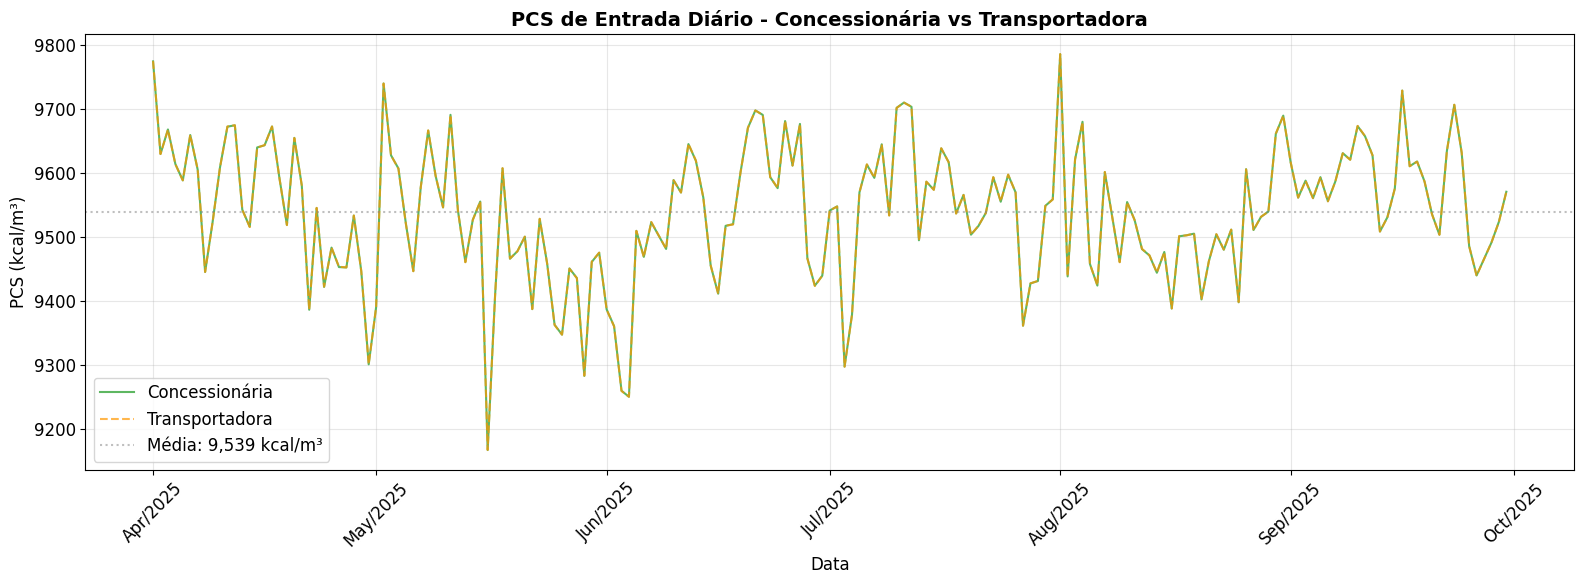

In [5]:
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(df['Data'], df['PCS_Conc_kcal'], 
        label='Concessionária', color='#4CAF50', linewidth=1.5, alpha=0.9)
ax.plot(df['Data'], df['PCS_Transp_kcal'], 
        label='Transportadora', color='#FF9800', linewidth=1.5, alpha=0.7, linestyle='--')

# Faixa de referência
media = df['PCS_Conc_kcal'].mean()
ax.axhline(y=media, color='gray', linestyle=':', alpha=0.5, 
           label=f'Média: {media:,.0f} kcal/m³')

ax.set_title('PCS de Entrada Diário - Concessionária vs Transportadora', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('PCS (kcal/m³)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'pcs_serie.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.2 Diferenças entre Concessionária e Transportadora

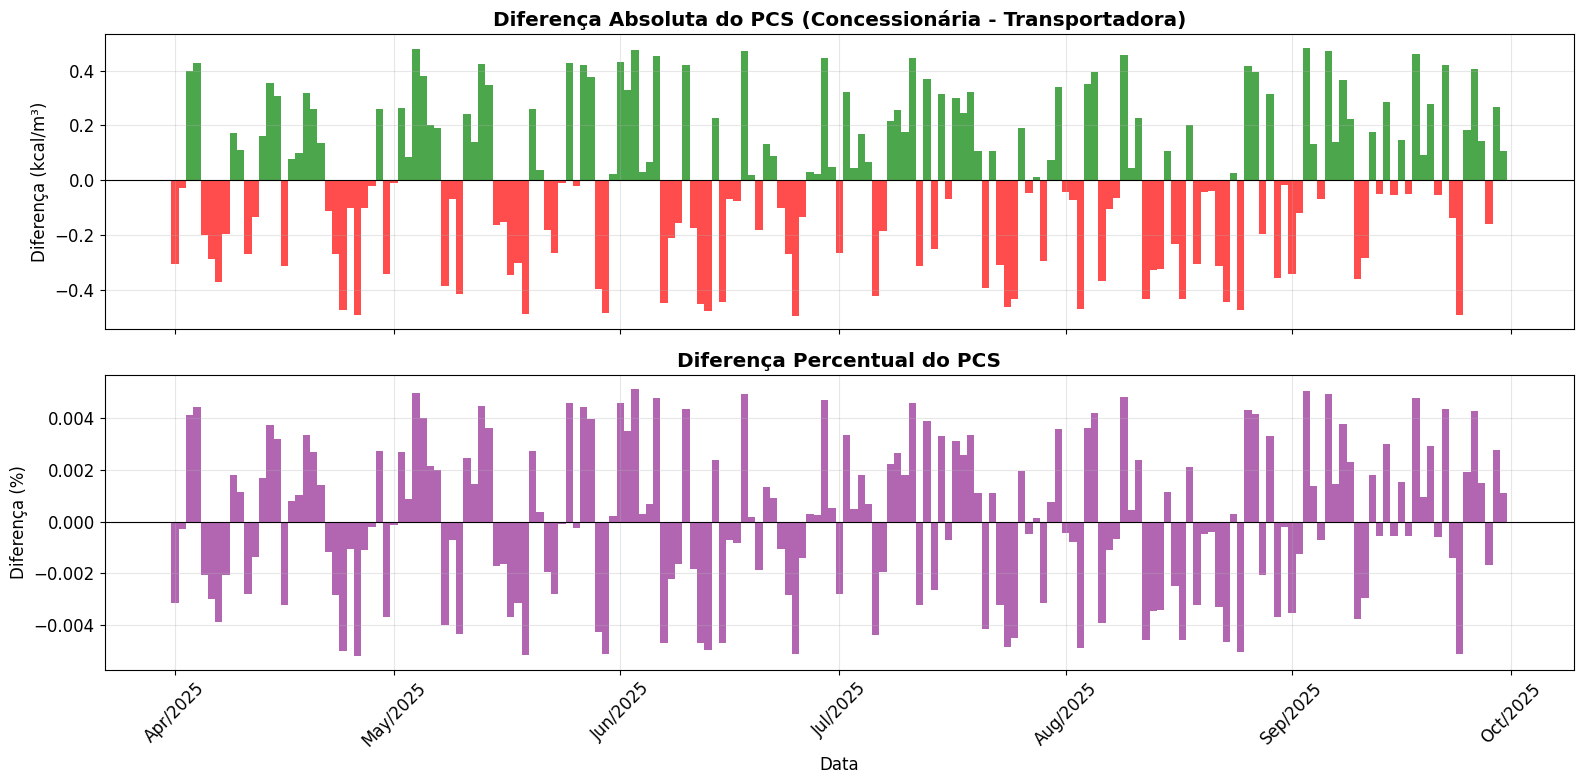

In [6]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

# Diferença absoluta
cores = ['green' if x >= 0 else 'red' for x in df['Dif_Abs_Calc']]
ax1.bar(df['Data'], df['Dif_Abs_Calc'], color=cores, alpha=0.7, width=1)
ax1.axhline(y=0, color='black', linewidth=0.8)
ax1.set_title('Diferença Absoluta do PCS (Concessionária - Transportadora)', fontweight='bold')
ax1.set_ylabel('Diferença (kcal/m³)')
ax1.grid(True, alpha=0.3)

# Diferença percentual
ax2.bar(df['Data'], df['Dif_Pct_Calc'], color='purple', alpha=0.6, width=1)
ax2.axhline(y=0, color='black', linewidth=0.8)
ax2.set_title('Diferença Percentual do PCS', fontweight='bold')
ax2.set_ylabel('Diferença (%)')
ax2.set_xlabel('Data')
ax2.grid(True, alpha=0.3)
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### 3.3 Histograma de Distribuição do PCS

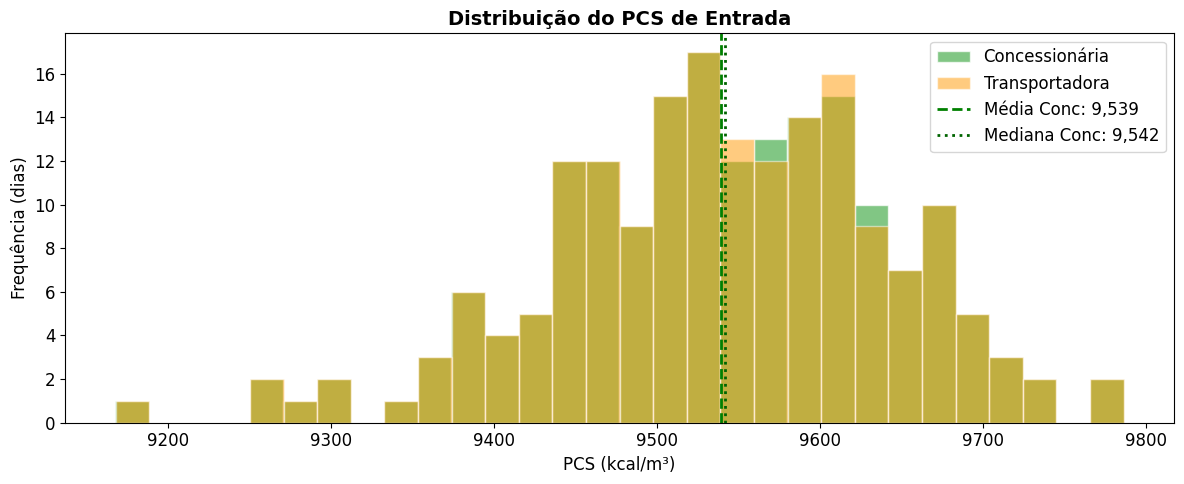

In [7]:
fig, ax = plt.subplots(figsize=(12, 5))

ax.hist(df['PCS_Conc_kcal'], bins=30, color='#4CAF50', edgecolor='white', 
        alpha=0.7, label='Concessionária')
ax.hist(df['PCS_Transp_kcal'], bins=30, color='#FF9800', edgecolor='white', 
        alpha=0.5, label='Transportadora')

ax.axvline(x=df['PCS_Conc_kcal'].mean(), color='green', linewidth=2, 
           linestyle='--', label=f'Média Conc: {df["PCS_Conc_kcal"].mean():,.0f}')
ax.axvline(x=df['PCS_Conc_kcal'].median(), color='darkgreen', linewidth=2, 
           linestyle=':', label=f'Mediana Conc: {df["PCS_Conc_kcal"].median():,.0f}')

ax.set_title('Distribuição do PCS de Entrada', fontsize=14, fontweight='bold')
ax.set_xlabel('PCS (kcal/m³)')
ax.set_ylabel('Frequência (dias)')
ax.legend()

plt.tight_layout()
plt.savefig(str(GRAFICOS_DIR / 'pcs_histograma.png'), dpi=150, bbox_inches='tight')
plt.show()

### 3.4 Análise de Tendência - Média Móvel

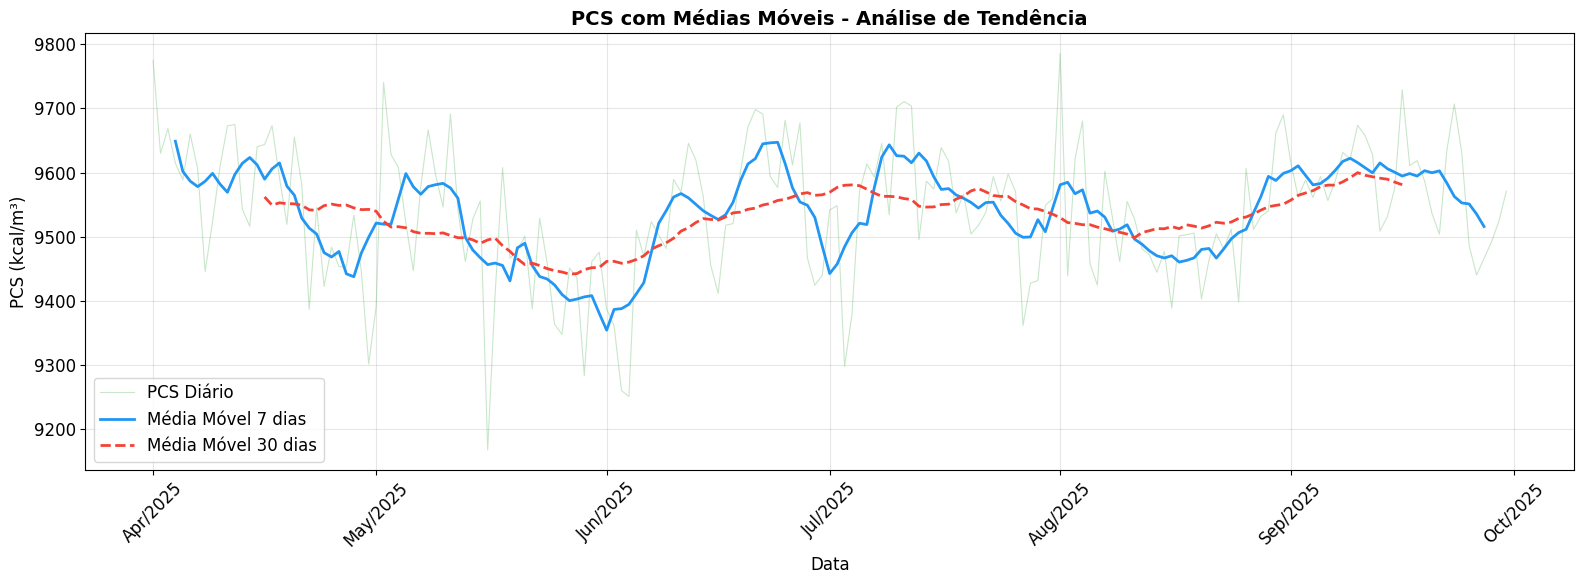

In [8]:
fig, ax = plt.subplots(figsize=(16, 6))

# Dados diários
ax.plot(df['Data'], df['PCS_Conc_kcal'], color='#4CAF50', alpha=0.3, 
        linewidth=0.8, label='PCS Diário')

# Médias móveis
for janela, cor, estilo in [(7, '#2196F3', '-'), (30, '#F44336', '--')]:
    mm = df['PCS_Conc_kcal'].rolling(window=janela, center=True).mean()
    ax.plot(df['Data'], mm, color=cor, linewidth=2, linestyle=estilo,
            label=f'Média Móvel {janela} dias')

ax.set_title('PCS com Médias Móveis - Análise de Tendência', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('PCS (kcal/m³)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b/%Y'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 3.5 Variação Mensal do PCS

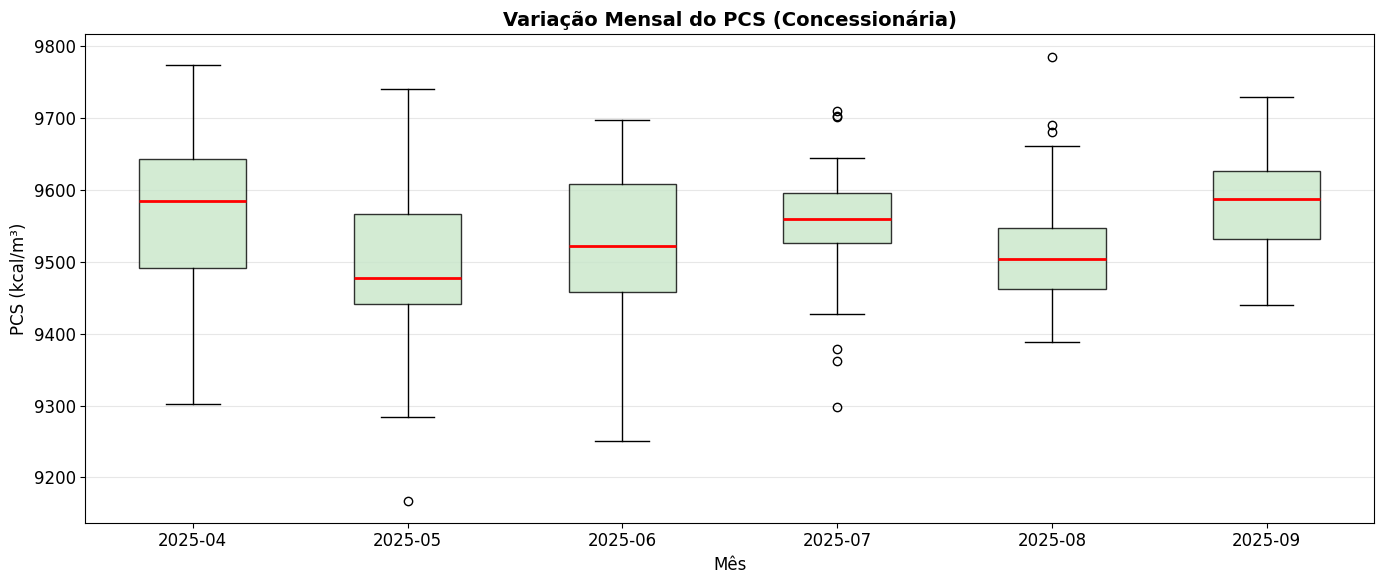

=== PCS Médio Mensal (kcal/m³) ===
               Média     Mínimo     Máximo  Desvio Padrão
Mes                                                      
2025-04  9562.002717  9301.6592  9774.6934     104.976352
2025-05  9494.438897  9167.8484  9740.2617     120.087478
2025-06   9525.80007  9251.0282  9698.1317     119.330074
2025-07  9550.407406  9298.0447  9710.4464      95.020470
2025-08   9521.44759   9388.766  9785.9555      92.681386
2025-09  9581.086693  9440.4048  9729.1475      69.011219


In [9]:
df['Mes'] = df['Data'].dt.to_period('M').astype(str)

fig, ax = plt.subplots(figsize=(14, 6))

meses = df['Mes'].unique()
dados_box = [df[df['Mes'] == m]['PCS_Conc_kcal'].values for m in meses]

bp = ax.boxplot(dados_box, labels=meses, patch_artist=True,
                boxprops=dict(facecolor='#C8E6C9', alpha=0.8),
                medianprops=dict(color='red', linewidth=2))

ax.set_title('Variação Mensal do PCS (Concessionária)', fontsize=14, fontweight='bold')
ax.set_xlabel('Mês')
ax.set_ylabel('PCS (kcal/m³)')
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Tabela resumo mensal
print('=== PCS Médio Mensal (kcal/m³) ===')
resumo = df.groupby('Mes')['PCS_Conc_kcal'].agg(['mean', 'min', 'max', 'std'])
resumo.columns = ['Média', 'Mínimo', 'Máximo', 'Desvio Padrão']
print(resumo.to_string())

## 4. Conclusões

### Observações:
- O PCS médio é de **~9.539 kcal/m³**, dentro da faixa típica de gás natural
- Variação de ~9.168 a ~9.786 kcal/m³ (amplitude de ~618 kcal/m³)
- As medições de Concessionária e Transportadora são muito próximas (diferenças < 0,01%)
- A qualidade do gás (composição) varia ao longo do tempo, afetando o PCS
- A média móvel de 30 dias ajuda a identificar tendências de longo prazo